In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tools_ryu import mytool

In [2]:
d = pd.read_pickle("coinmarketcap_data/coinmarketcap_data.pickle")
vol = pd.pivot_table(data=d,
                     values="vol",
                     index="date",
                     columns="coin_id"
                     )

In [3]:
vol_mask = (vol.rolling(window=20, min_periods=1).mean() > 1_00_000).replace({True:1,
                                                                             False: np.nan})

In [4]:
mktcap = pd.read_pickle("mktcap_pp.pickle")
price = pd.read_pickle("close_pp.pickle").replace(0,np.nan)

daily_rtn = price.pct_change(fill_method=None)

mktcap_screened = (mktcap[mktcap > 1_000_000] * vol_mask)

In [5]:
# 시작일 찾기
start_idx = (mktcap_screened.isna().sum(1) < 10616).replace(False,np.nan).dropna().index[0]

# weight 계산
weight = mktcap_screened.loc[start_idx:].apply(lambda x: x / np.nansum(x), axis=1)

In [6]:
# 마켓 인덱스 만들기
mkt_index = (daily_rtn*weight.shift(1)).sum(1)

In [7]:
# 모멘텀 그룹을 나눌 때 사용한다
daily_rtn_pp = daily_rtn * np.sign(mktcap_screened)

In [8]:
# 언제부터 시작하는 지 찾자 (최소 100개의 코인이 필요)
cnt = daily_rtn_pp.count(1)
more100 = cnt.loc[cnt > 99] # 여기서 start date가 나온다
start = more100.index[0]
more100

date
2017-05-19     101
2017-05-22     106
2017-05-23     107
2017-05-24     110
2017-05-25     109
              ... 
2023-04-12    1056
2023-04-13    1057
2023-04-14    1059
2023-04-15    1060
2023-04-16    1064
Length: 2157, dtype: int64

In [9]:
rtn_sample_pp = daily_rtn_pp.loc[start:]
mktcap_sample = mktcap_screened.loc[start:]
price_sample = price.loc[start:]

In [10]:
# rank를 계산해줍니다
rank = rtn_sample_pp.rank(axis=1, method="first")

# rank가 존재하는 코인의 수를 구합니다
coin_count = rank.count(axis=1)

# 그룹별로 동일한 코인 수를 포함하기 위해 각 그룹의 rank thresh를 생성해줍니다
rank_thresh = coin_count.apply(lambda x: [i for i in range(0,x, x//5)])

t1 = rank_thresh.apply(lambda x: x[1])
t2 = rank_thresh.apply(lambda x: x[2])
t3 = rank_thresh.apply(lambda x: x[3])
t4 = rank_thresh.apply(lambda x: x[4])

rank_thresh

date
2017-05-19         [0, 20, 40, 60, 80, 100]
2017-05-20              [0, 17, 34, 51, 68]
2017-05-21          [0, 17, 34, 51, 68, 85]
2017-05-22         [0, 21, 42, 63, 84, 105]
2017-05-23         [0, 21, 42, 63, 84, 105]
                          ...              
2023-04-12    [0, 211, 422, 633, 844, 1055]
2023-04-13    [0, 211, 422, 633, 844, 1055]
2023-04-14    [0, 211, 422, 633, 844, 1055]
2023-04-15          [0, 212, 424, 636, 848]
2023-04-16    [0, 212, 424, 636, 848, 1060]
Length: 2159, dtype: object

In [11]:
g1_mask = rank.apply(lambda x: x <= t1, axis=0) \
              .replace({True:1, False:np.nan})
g2_mask = rank.apply(lambda x: (t1 < x)&(x <= t2), axis=0) \
              .replace({True:1, False:np.nan})
g3_mask = rank.apply(lambda x: (t2 < x)&(x <= t3), axis=0) \
              .replace({True:1, False:np.nan})
g4_mask = rank.apply(lambda x: (t3 < x)&(x <= t4), axis=0) \
              .replace({True:1, False:np.nan})
g5_mask = rank.apply(lambda x: x > t4, axis=0) \
              .replace({True:1, False:np.nan})           

In [12]:
# 각 그룹별 weight를 생성
weight_g1 = (g1_mask * mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g2 = (g2_mask * mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g3 = (g3_mask * mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g4 = (g4_mask * mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g5 = (g5_mask * mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)

In [13]:
# 그날 리턴을 확인해보자
r1 = (g1_mask * daily_rtn.loc[start:]).mean(1)
r2 = (g2_mask * daily_rtn.loc[start:]).mean(1)
r3 = (g3_mask * daily_rtn.loc[start:]).mean(1)
r4 = (g4_mask * daily_rtn.loc[start:]).mean(1)
r5 = (g5_mask * daily_rtn.loc[start:]).mean(1)

pd.concat([r1,r2,r3,r4,r5], axis=1, keys=["Q1","Q2","Q3","Q4","Q5"])

,Q1,Q2,Q3,Q4,Q5
date,,,,,
2017-05-19,-0.104720,0.021084,0.061351,0.118116,0.329985
2017-05-20,-0.044199,0.017647,0.063027,0.109906,0.326623
2017-05-21,-0.121307,-0.016987,0.020553,0.090874,0.562772
2017-05-22,-0.122588,-0.062166,-0.012736,0.051840,0.428274
2017-05-23,-0.037457,0.072211,0.112129,0.162230,0.349868
...,...,...,...,...,...
2023-04-12,-0.062343,-0.022818,-0.009860,0.003794,0.073091
2023-04-13,-0.035228,0.005838,0.017744,0.032687,0.102771
2023-04-14,-0.039039,-0.000049,0.011485,0.027452,0.093214


In [14]:
# filter를 마켓켑과 리턴에 곱해줘서 각 그룹별 리턴 계산
rtn_g1 = (daily_rtn.loc[start:] * weight_g1.shift(1))#.sum(1)
rtn_g2 = (daily_rtn.loc[start:] * weight_g2.shift(1))#.sum(1)
rtn_g3 = (daily_rtn.loc[start:] * weight_g3.shift(1))#.sum(1)
rtn_g4 = (daily_rtn.loc[start:] * weight_g4.shift(1))#.sum(1)
rtn_g5 = (daily_rtn.loc[start:] * weight_g5.shift(1))#.sum(1)

In [15]:
# 그룹별 코인 개수 출력 
concat2 = pd.concat([rtn_g1.count(1), rtn_g2.count(1),
                    rtn_g3.count(1), rtn_g4.count(1),
                    rtn_g5.count(1)], axis=1)#.plot();

coin2 = pd.concat([concat2, concat2.sum(1)], axis=1)
coin2.columns = [0,1,2,3,4,"Sum"]

coin2.iloc[:10]

,0,1,2,3,4,Sum
date,,,,,,
2017-05-19,0,0,0,0,0,0
2017-05-20,16,17,18,16,18,85
2017-05-21,17,17,17,17,17,85
2017-05-22,17,17,17,17,19,87
2017-05-23,21,21,21,21,22,106
2017-05-24,21,21,21,21,23,107
2017-05-25,22,22,22,22,22,110
2017-05-26,21,21,21,21,25,109
2017-05-27,22,22,22,22,24,112


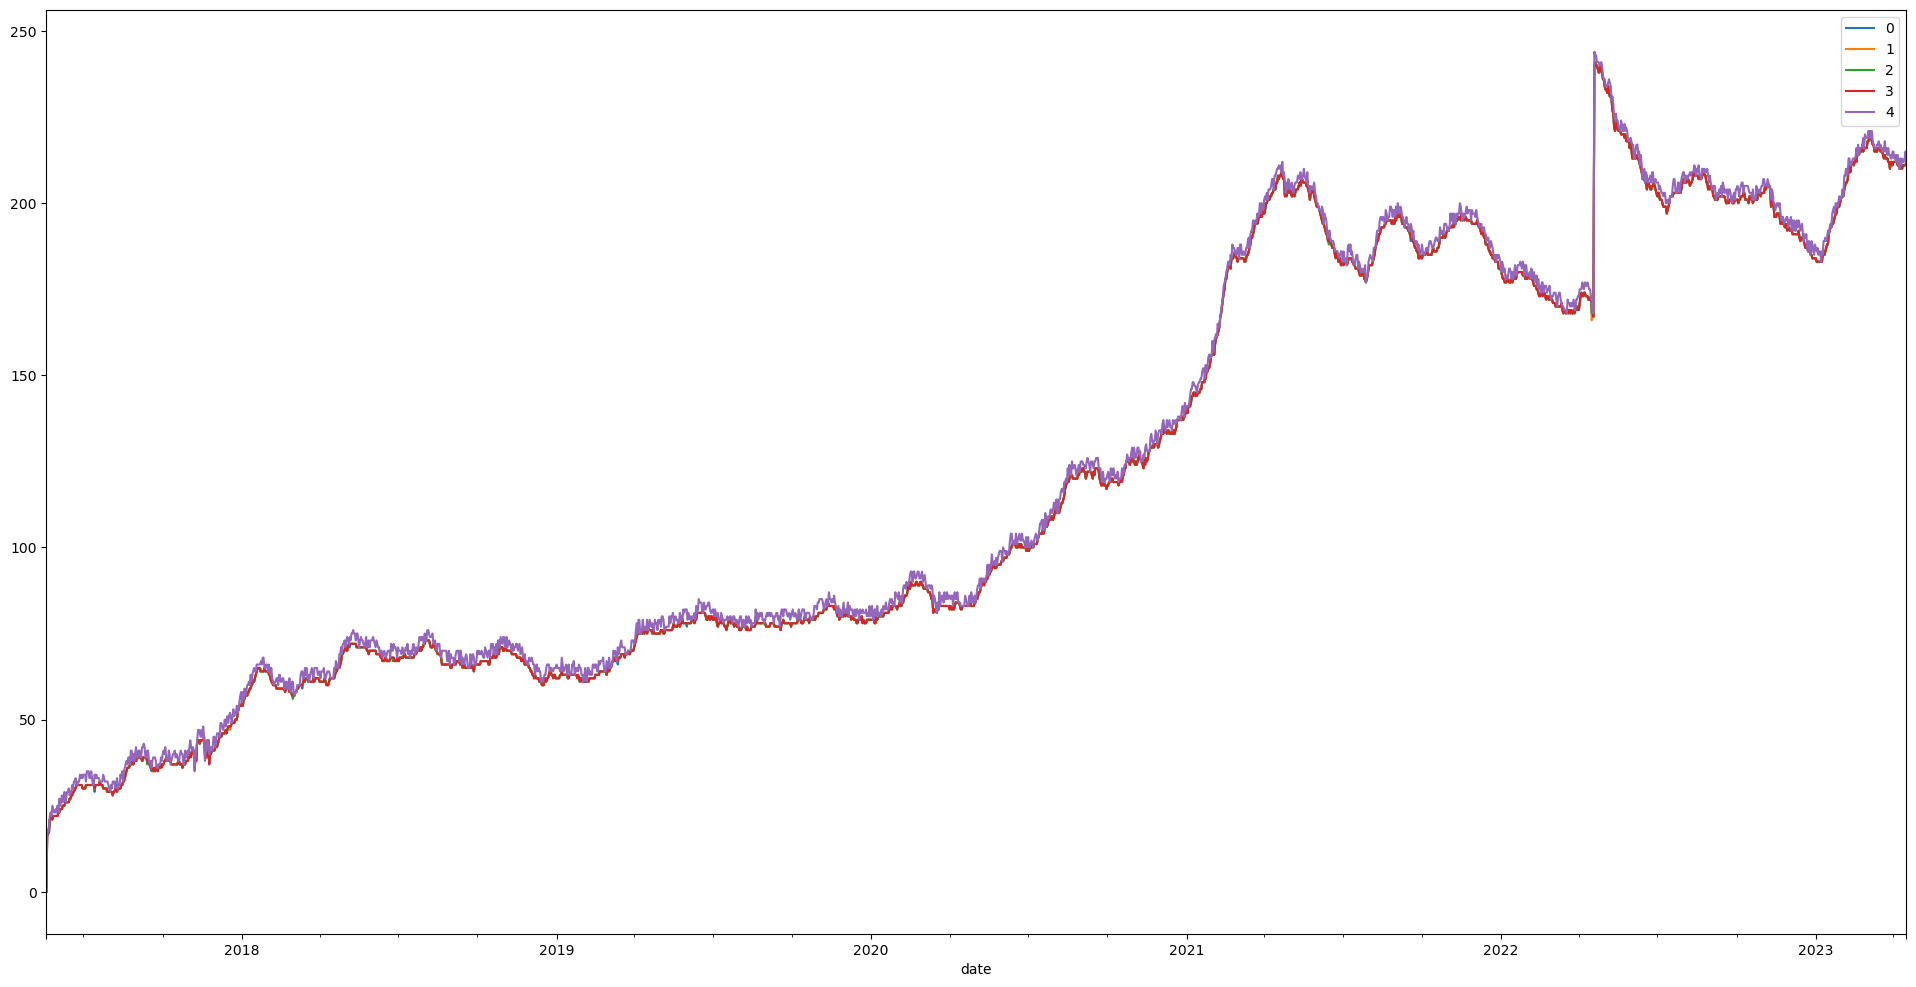

In [16]:
concat2.plot(figsize=(24,12));

In [17]:
rtn_dict = {"Q1":rtn_g1.sum(1),
            "Q2":rtn_g2.sum(1),
            "Q3":rtn_g3.sum(1),
            "Q4":rtn_g4.sum(1),
            "Q5":rtn_g5.sum(1)}

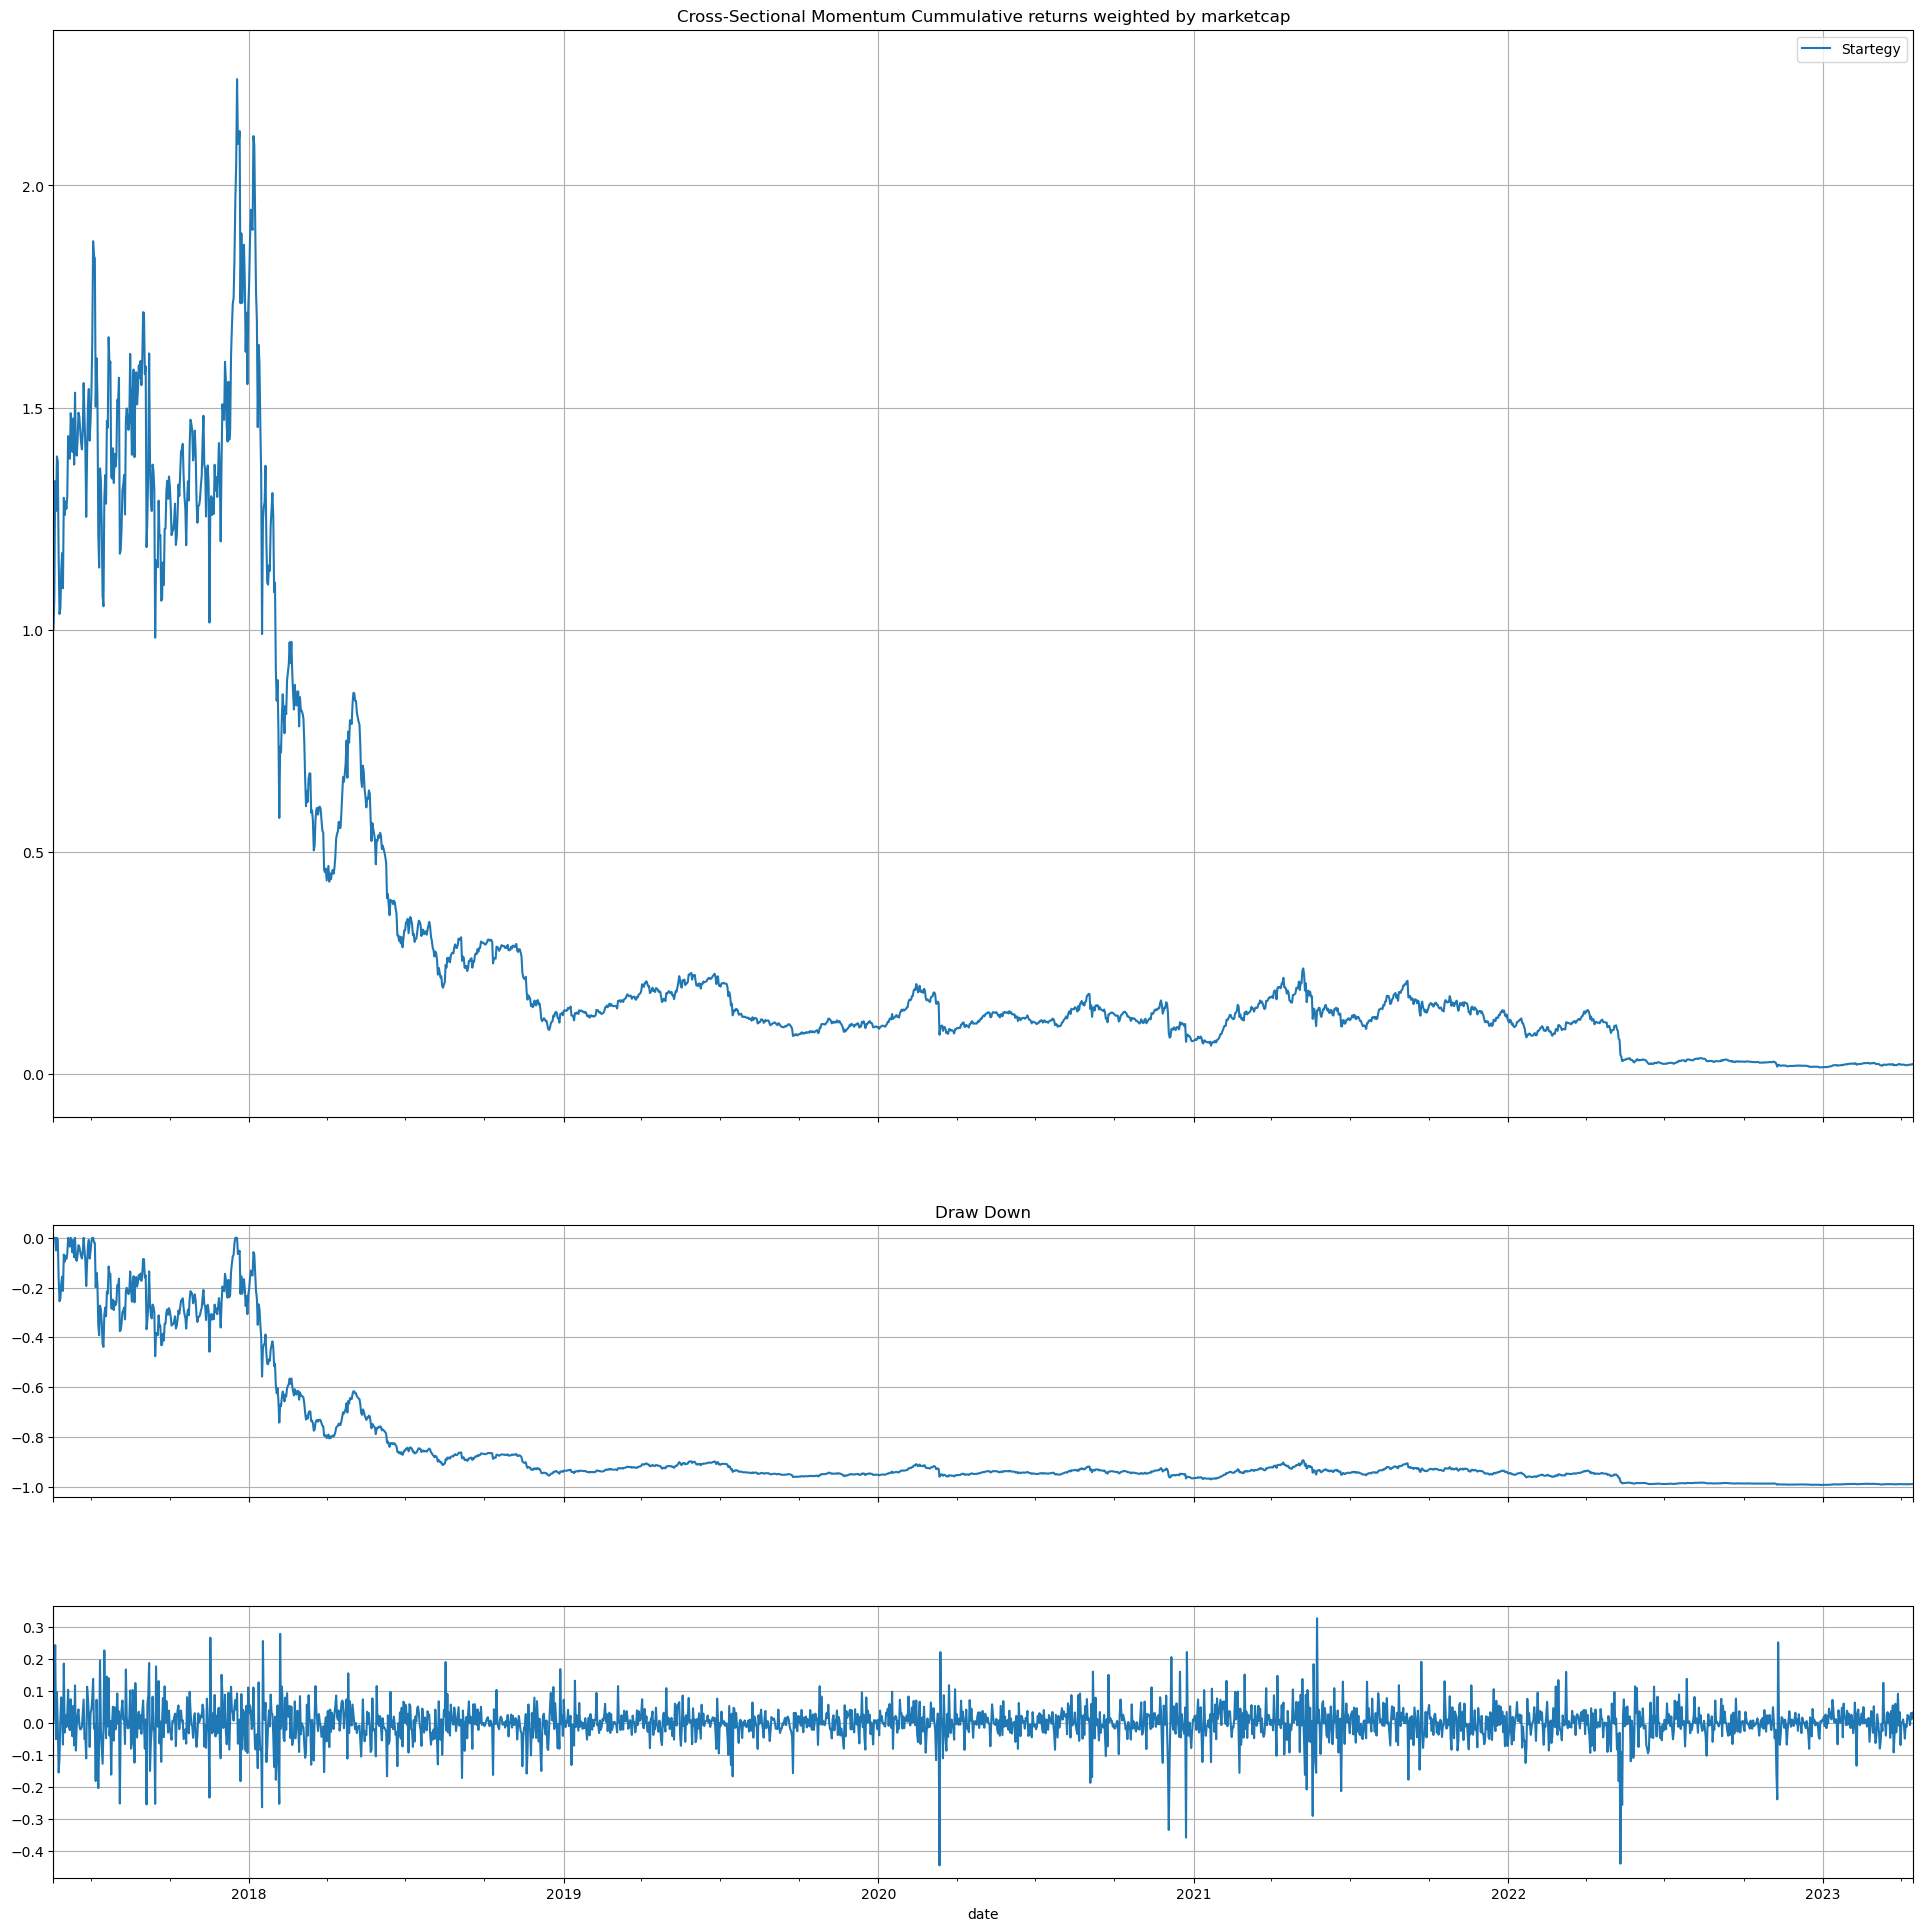

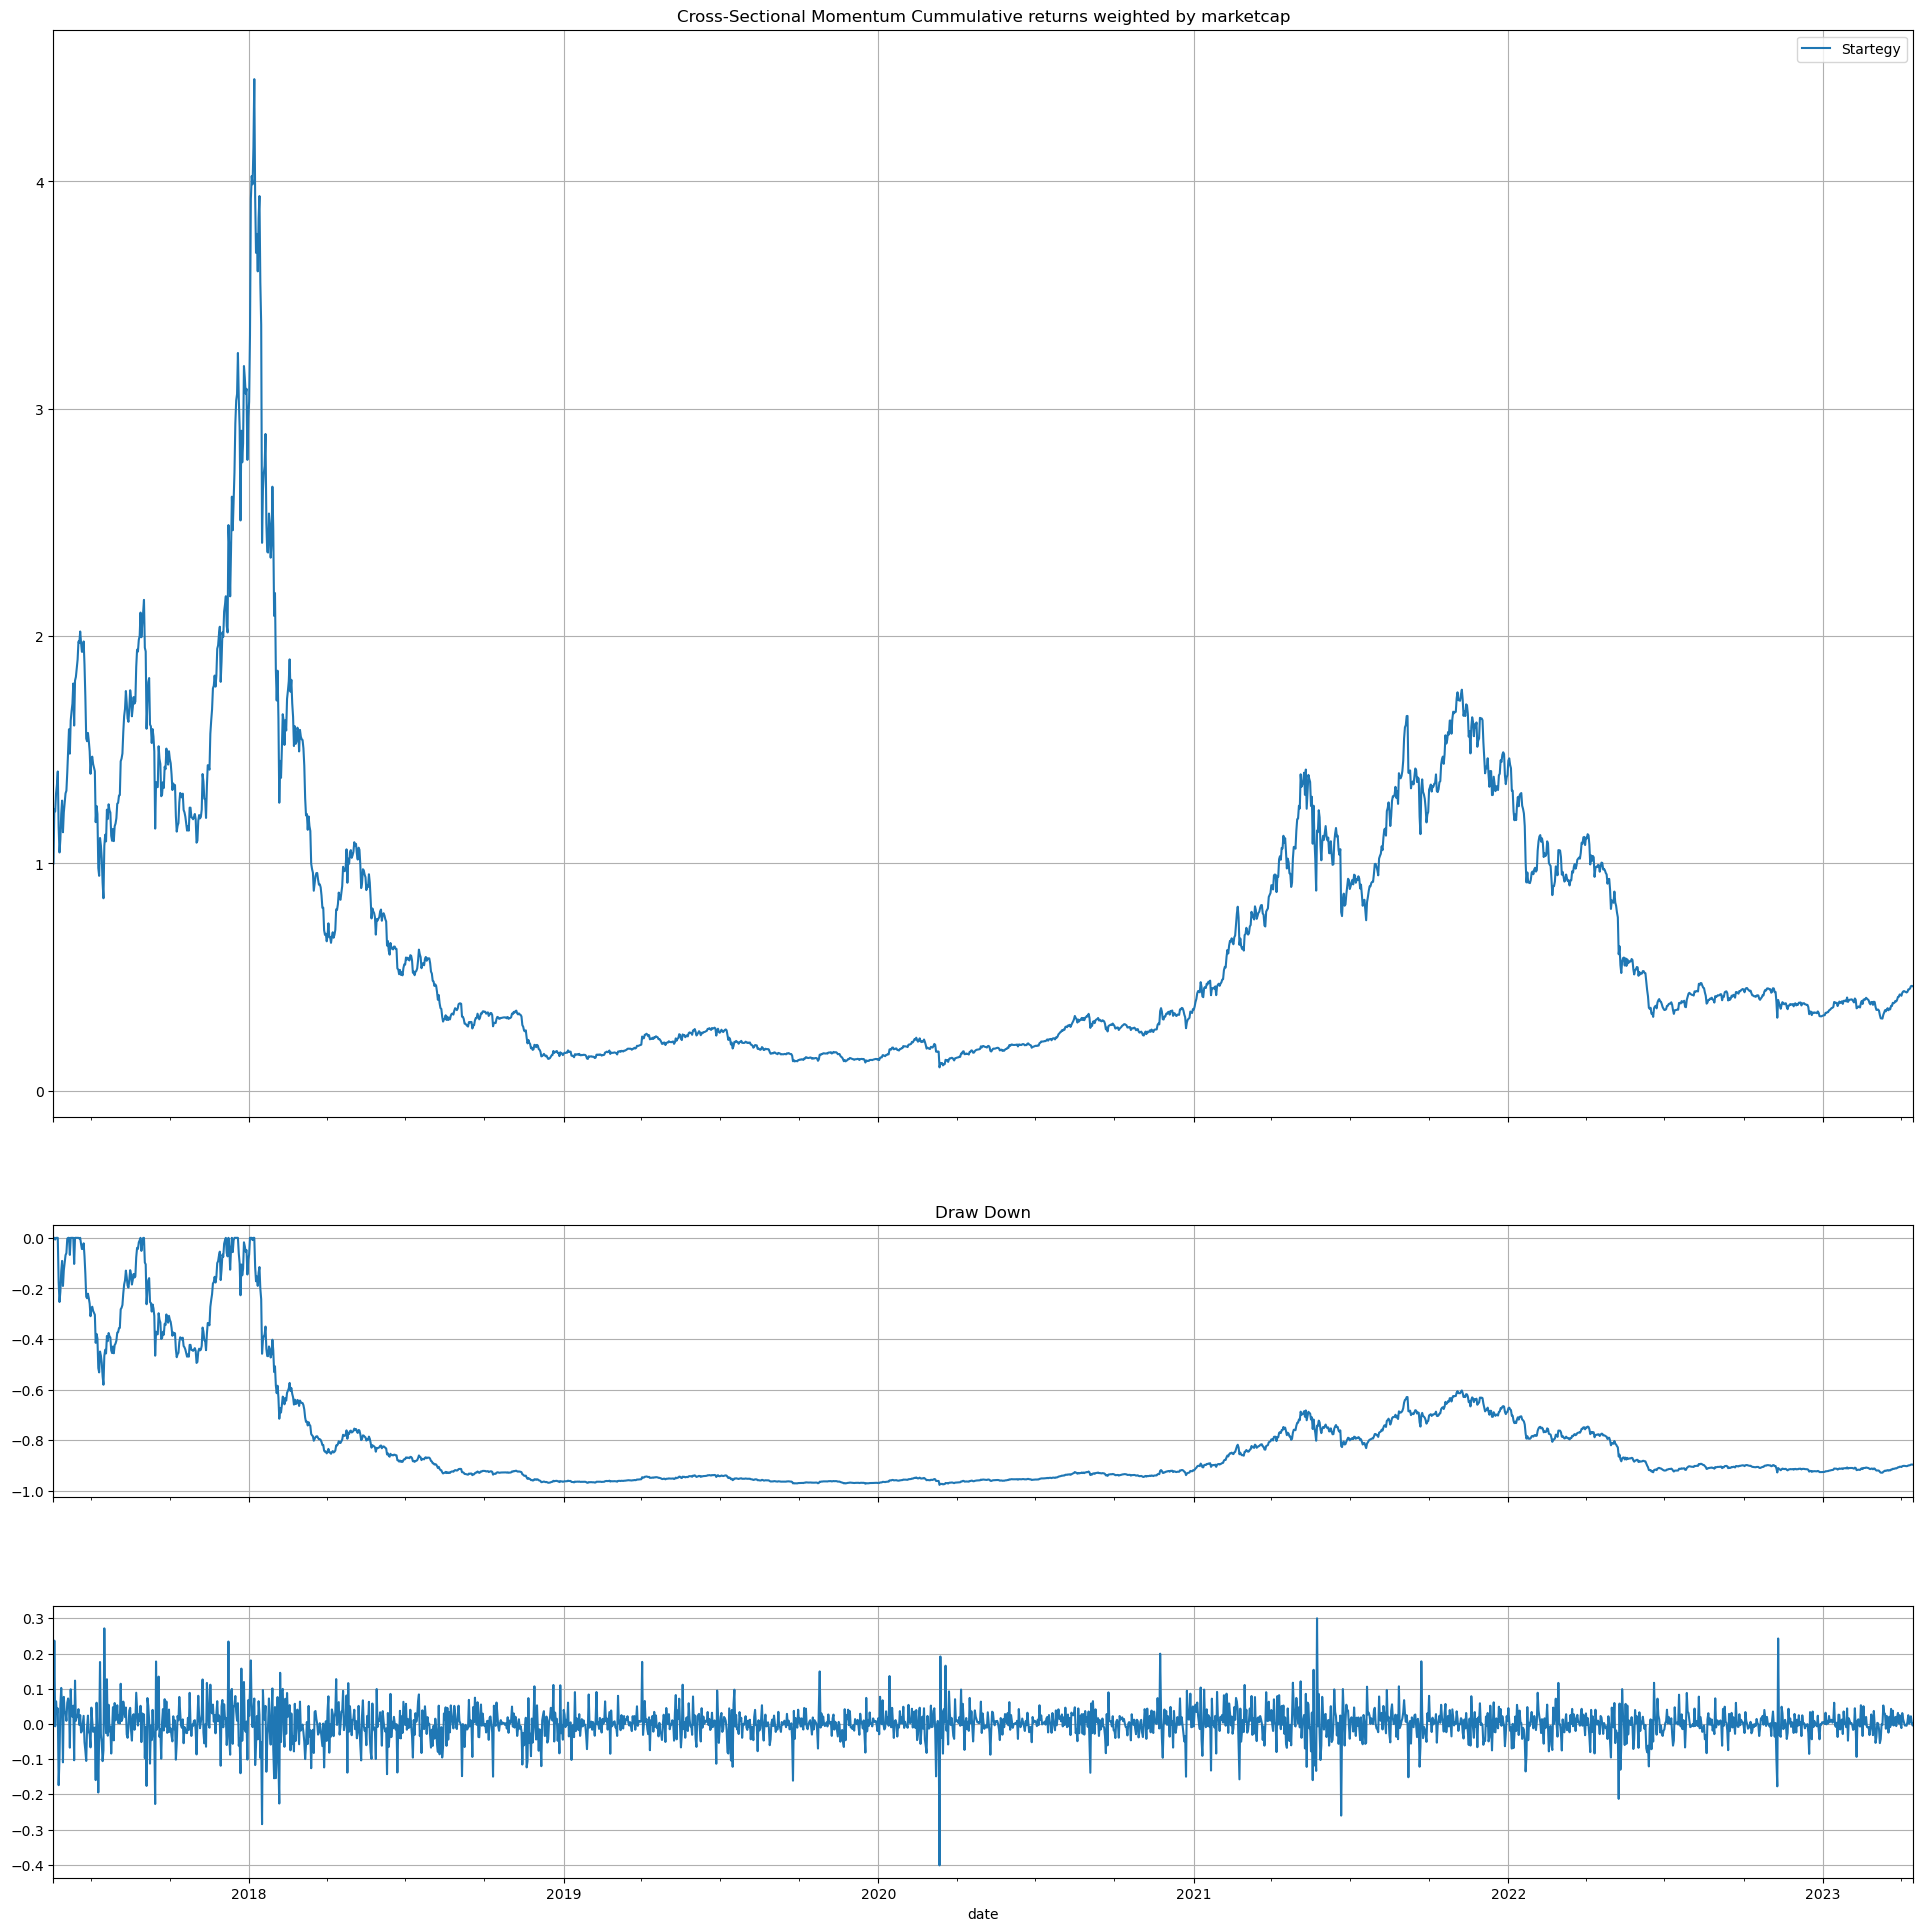

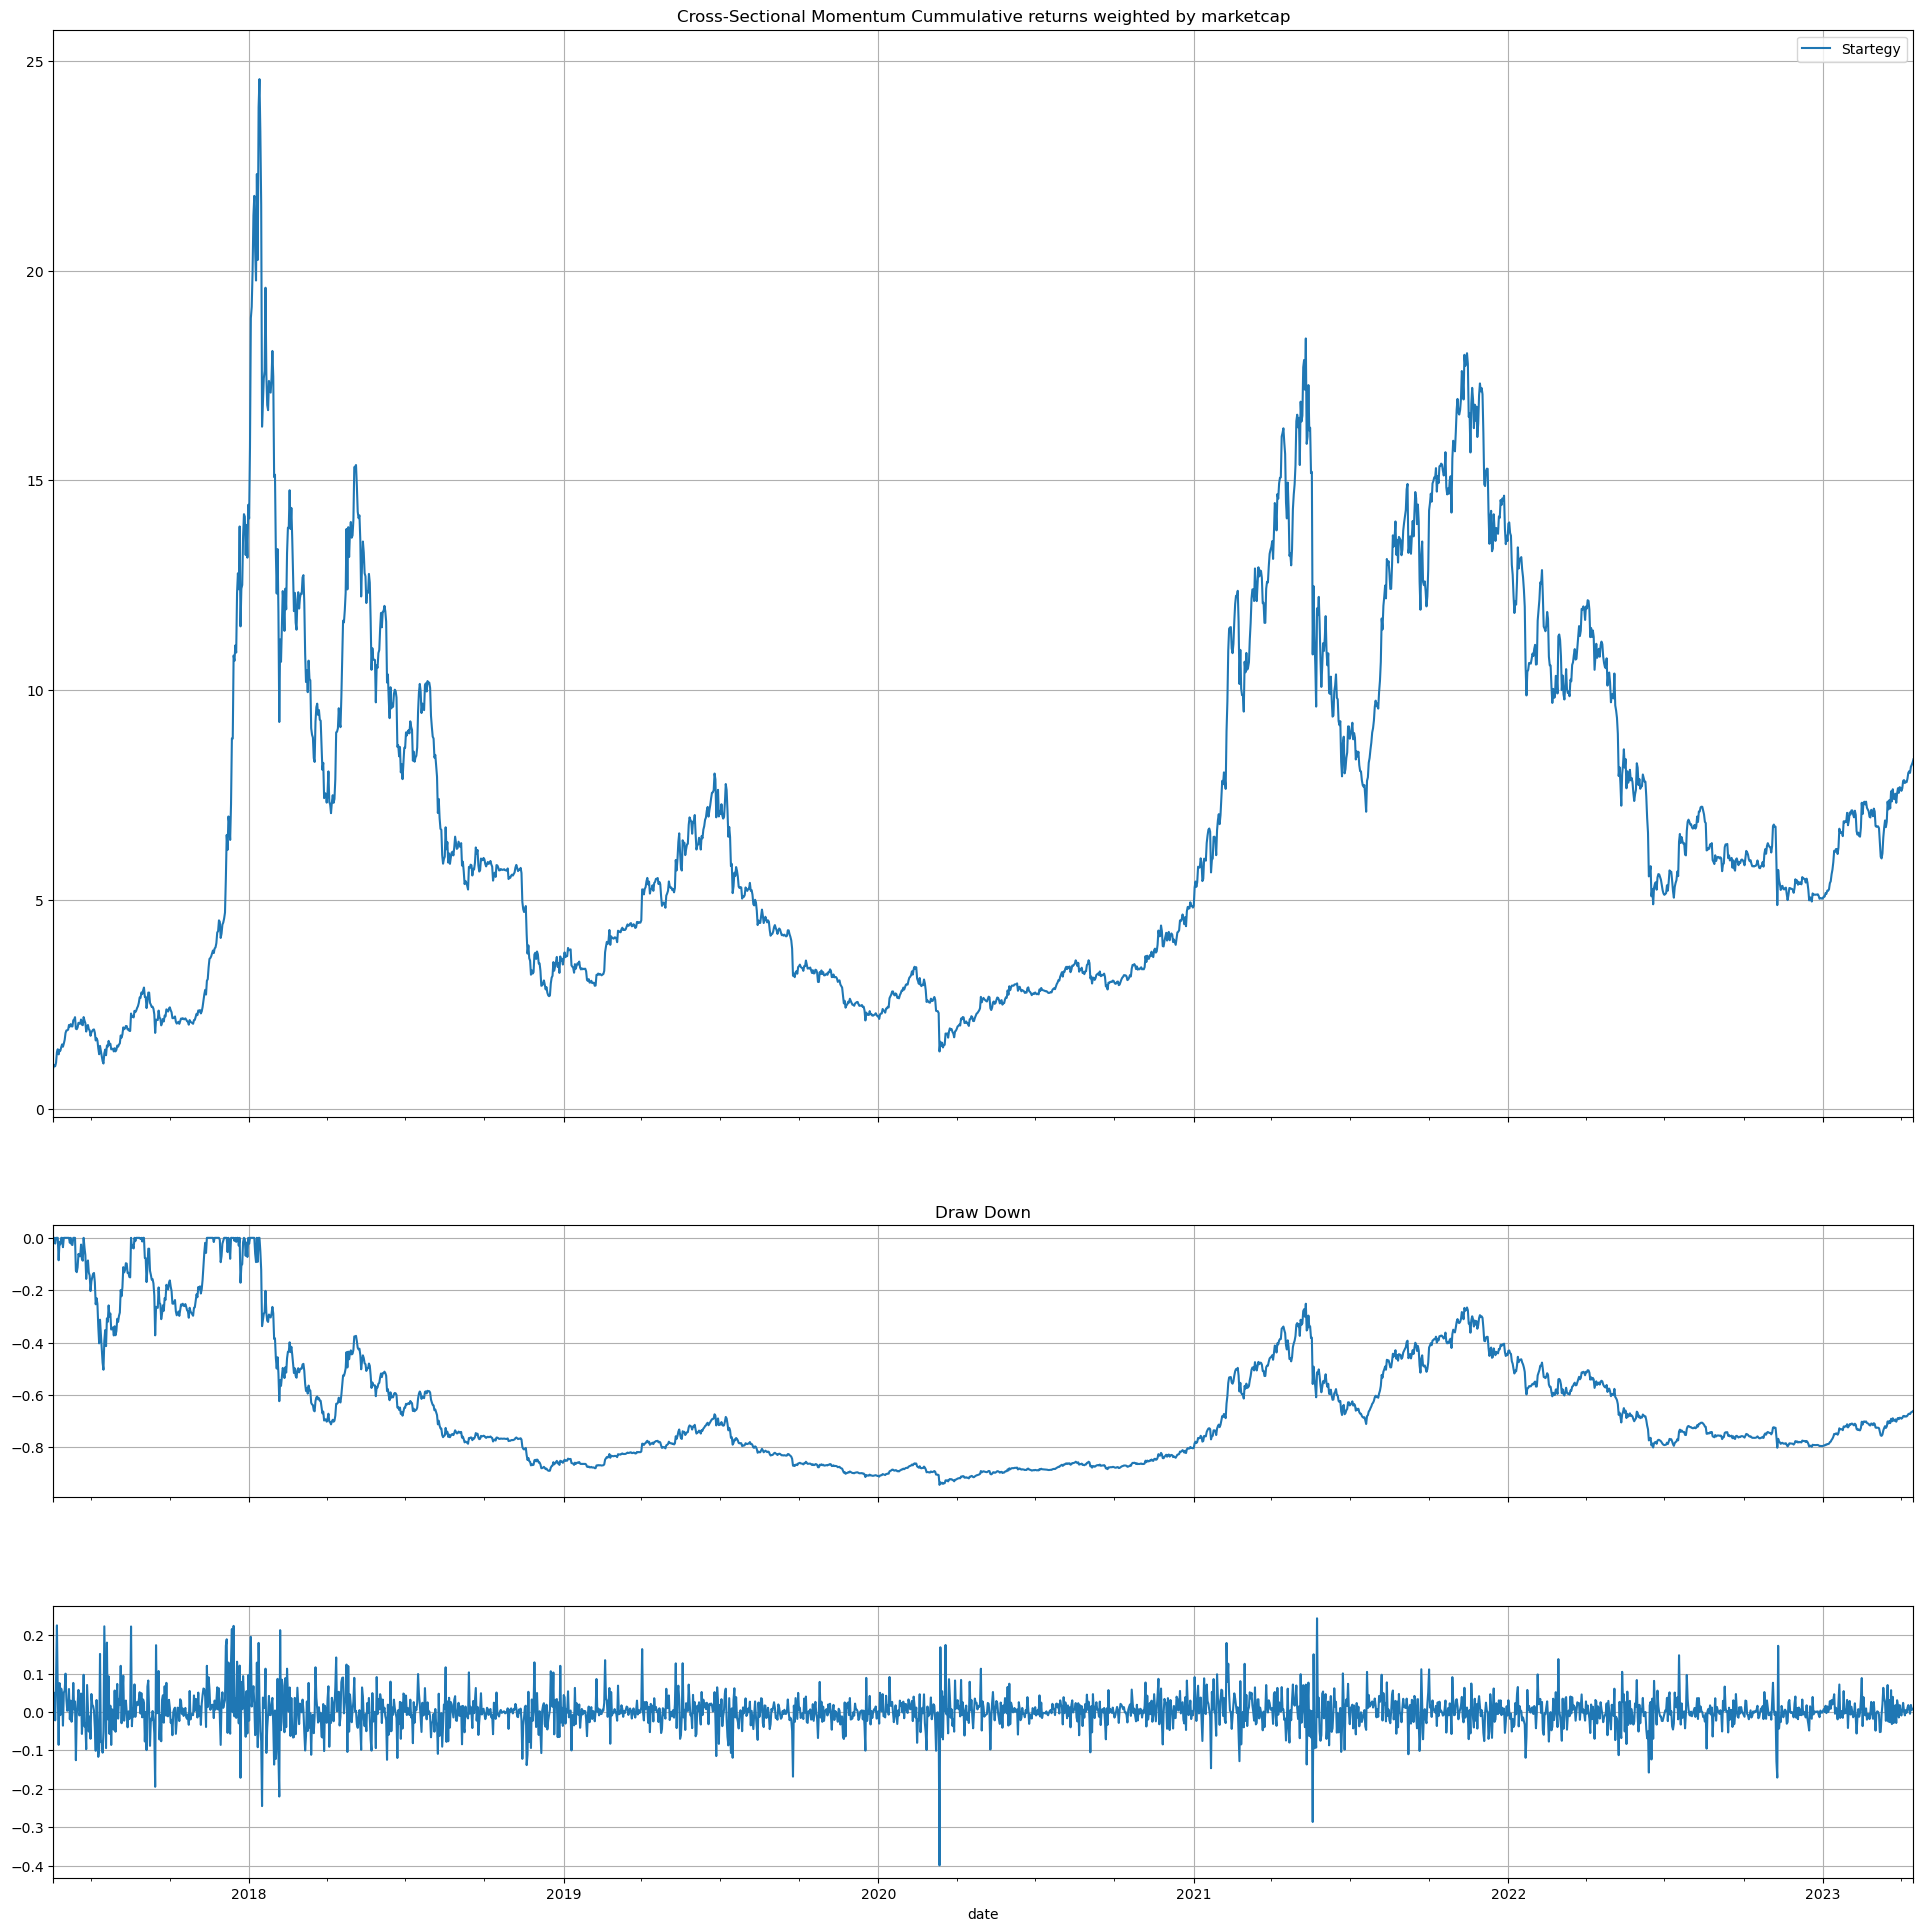

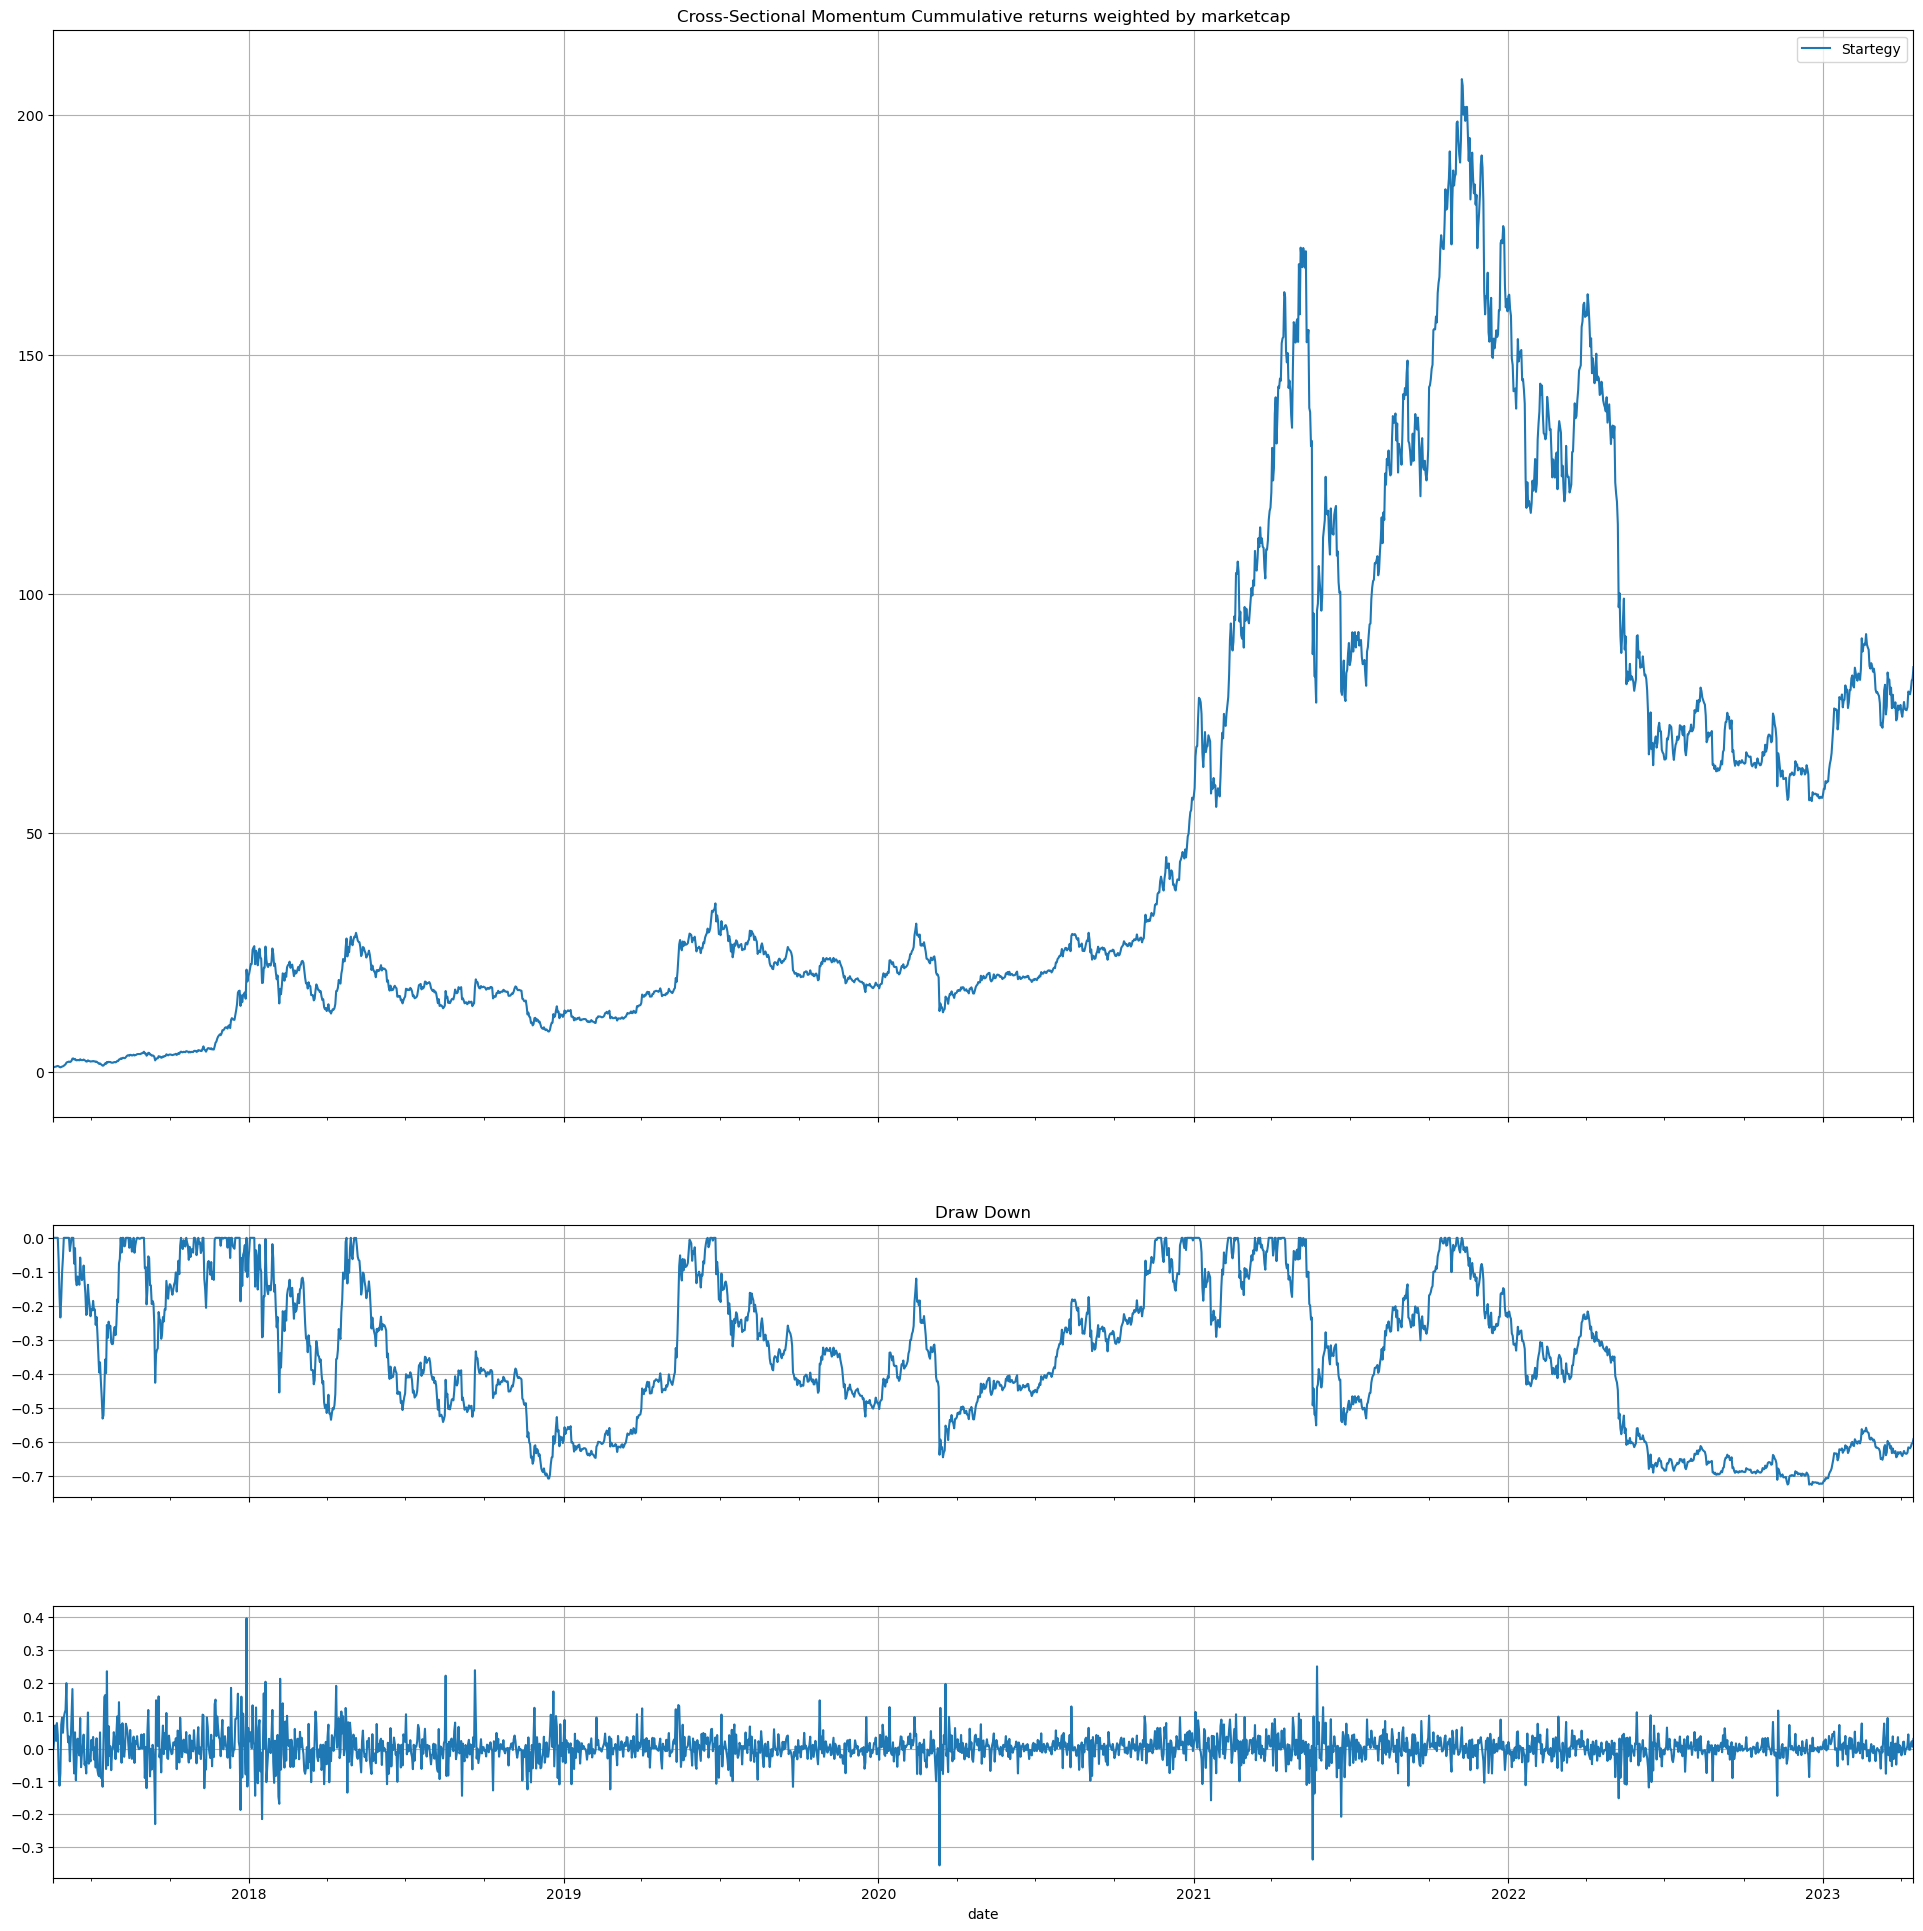

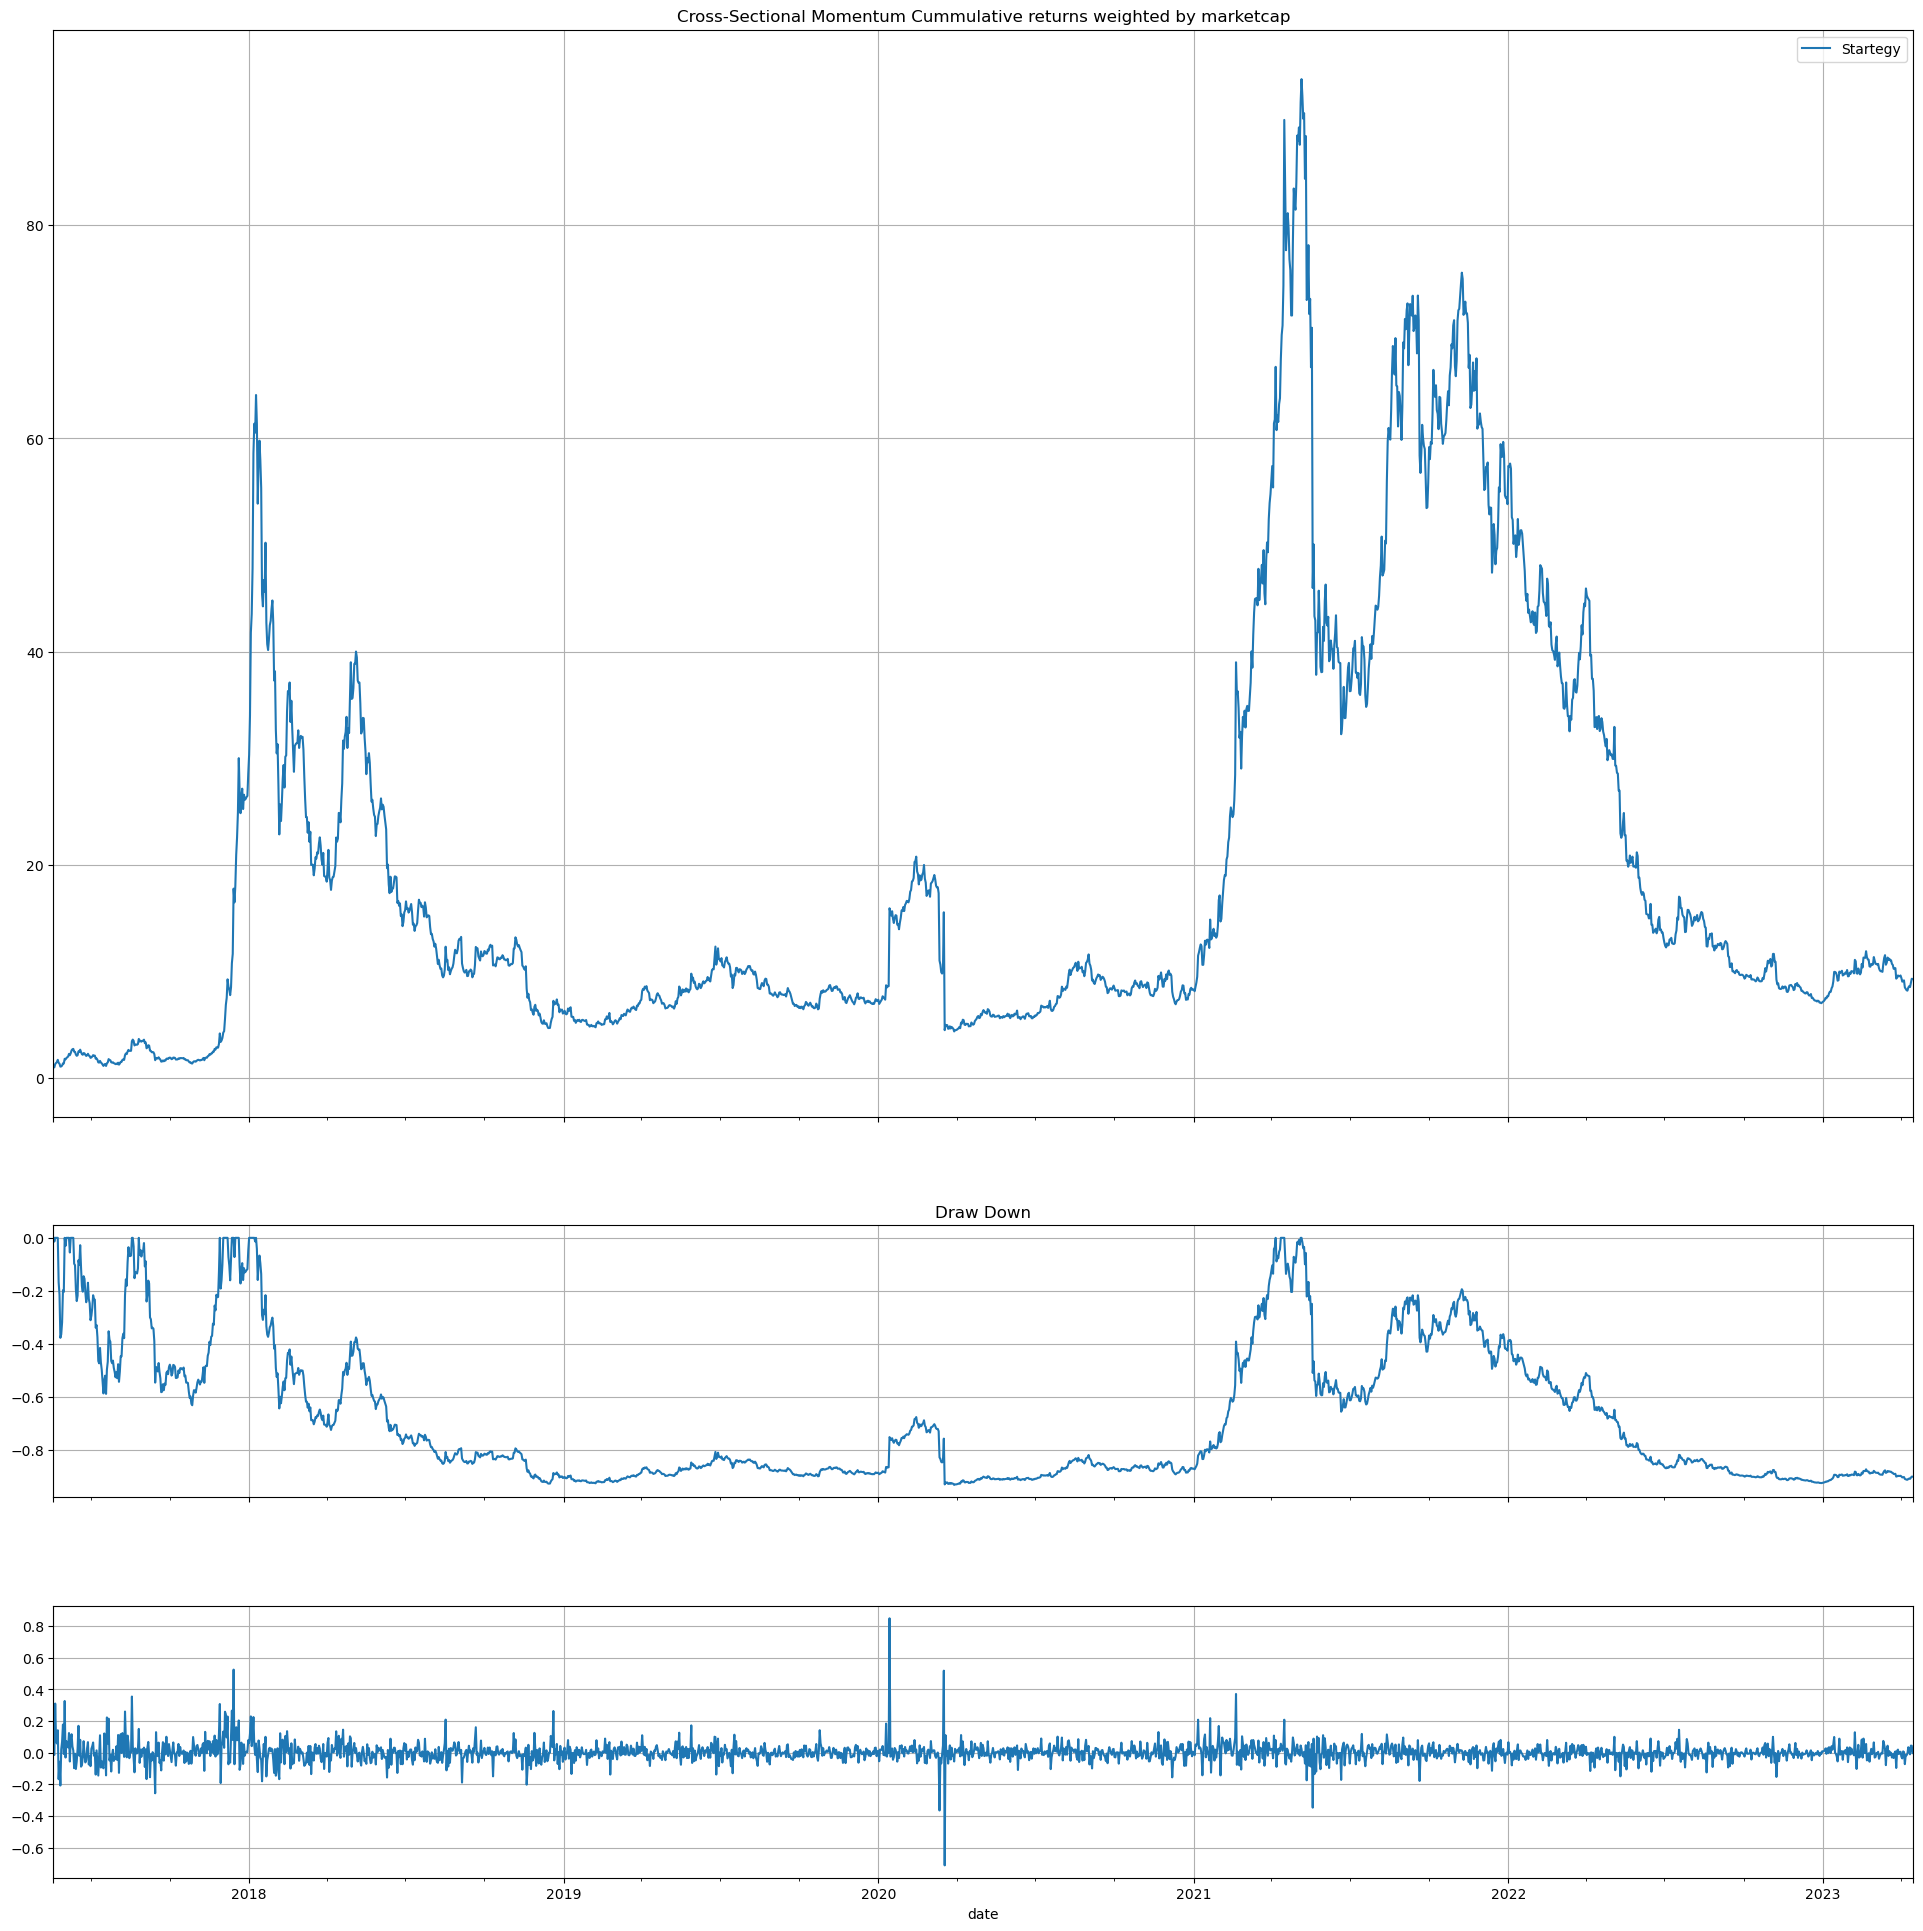

In [18]:
mytool.draw_return_result(rtn_dict, with_mkt=False)

In [19]:
mytool.print_statistics(rtn_dict, mkt_rtn=mkt_index.loc[start:])

,0,1,2,3,4,MKT
CAGR,-47.212625,-12.302187,43.153739,111.781549,45.672917,41.444572
Mean,-0.003355,0.292965,0.746323,1.157386,1.089439,0.001804
STD,1.101615,0.911228,0.875601,0.900501,1.185339,0.040264
Shape,-0.003046,0.321506,0.852355,1.285269,0.919095,0.044809


<AxesSubplot:xlabel='date'>

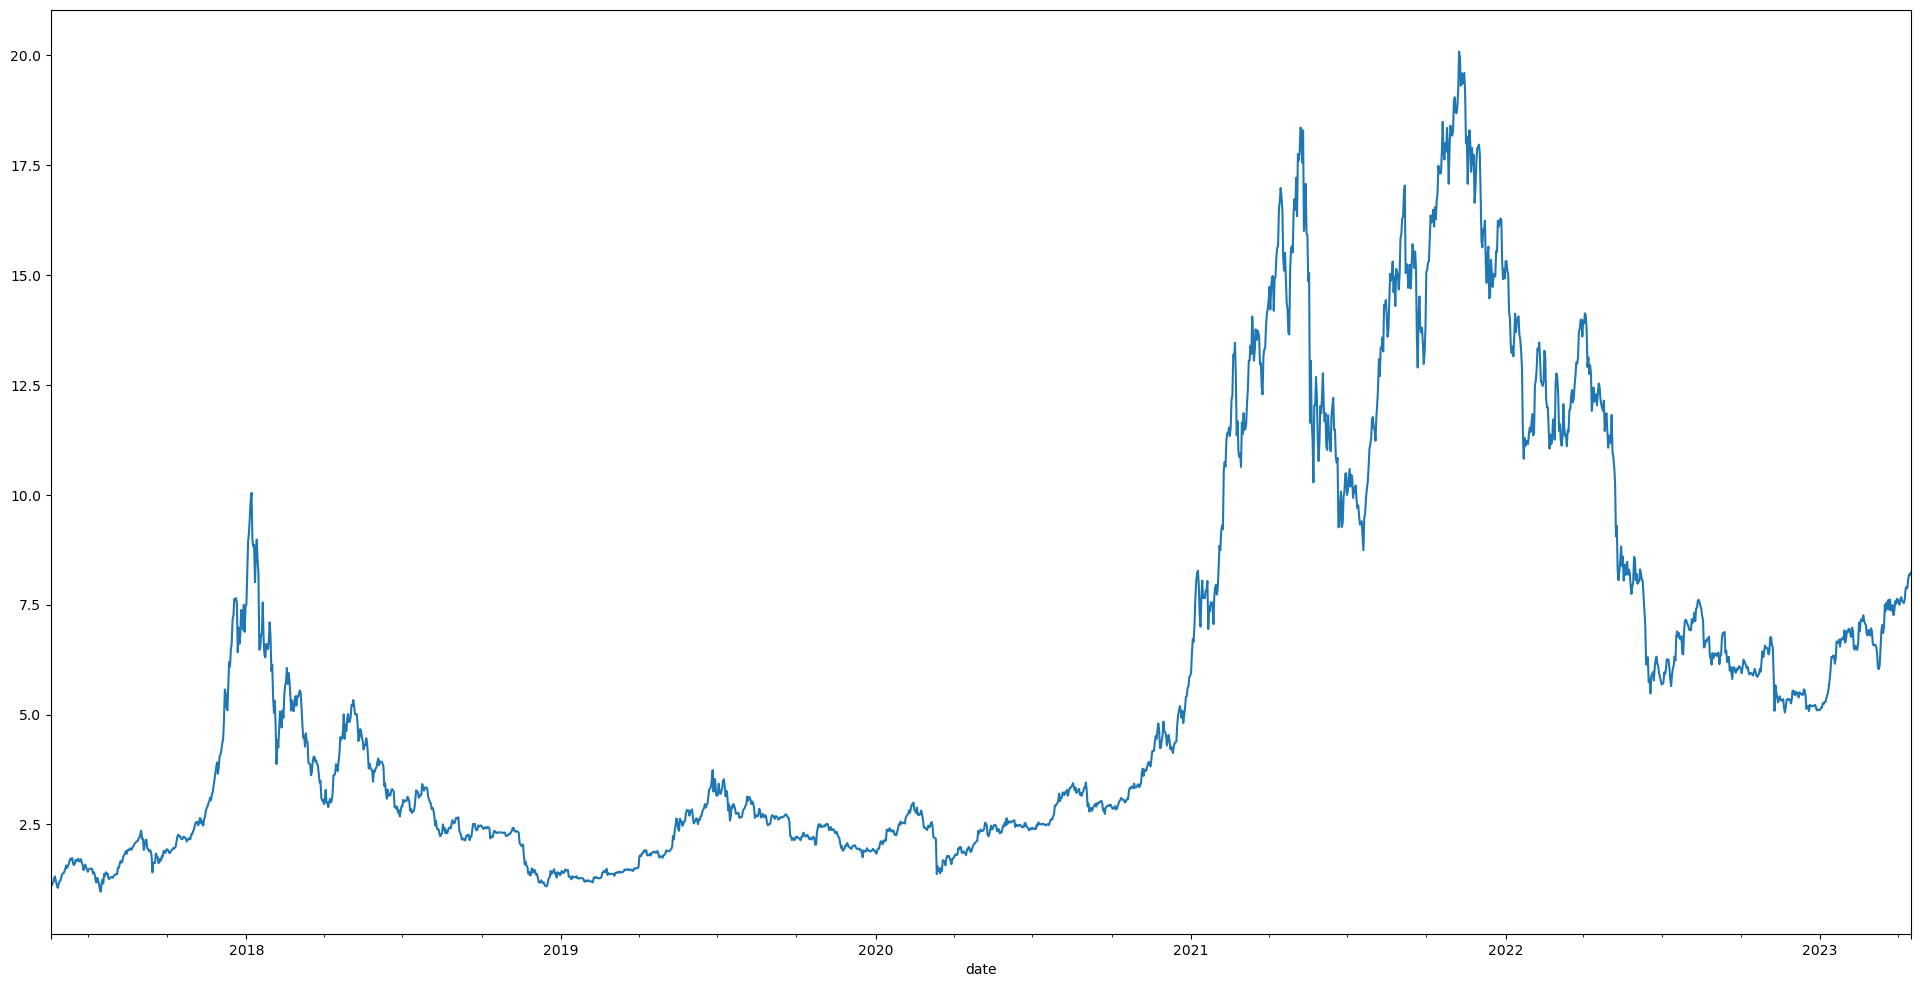

In [20]:
(mkt_index[start:]+1).cumprod().plot(figsize=(24,12))